# Mediciones en el patio del IAFE 

## Análisis de las mediciones

- S1: medición con placa conductora.
- S2: medición sobre la tierra del patio-

* **S_cal = S1**: señal de calibración.
* **S_target = S2**: señal reflejada por el target de interés.

> **La señal de calibración** es la que, idealmente, emite la antena. Si uno pudiese modelar de punta a punta la antena y hacer todas las cuentas necesarias, obtendría que la antena emite el pulso $S_{cal}(t)$, o bien su transformada de Fourier $\hat{S}_{cal}(f)$. Esto lo decimos porque medimos esta señal luego de la reflexión con un target que tiene el coeficiente de reflexión $|R|=1$. Está claro que esto es una hipótesis fuerte, que deberá ser corregida luego. Además, falta contemplar el factor de decaimiento de la señal debido al camino de ida-vuelta entre la antena emisora y la antena receptora. Pero este factor -geométrico- es independiente de las frecuencias del paquete de ondas y del target, así que por ahora podemos ignorarlo.


> **La señal del target** es la que debemos analizar para obtener alguna de las propiedades del blanco en estudio. En principio desconocemos la constante dieléctrica $\epsilon(\omega)$ que tiene la placa dieléctrica de espesor $D$ puesta sobre el conductor ideal. Y, en principio, la señal reflejada por este target que recibe la antena  es $S_{teo}=R(\omega)\,\times\,S_{antena}(\omega)=R(\omega)\,\times\,S_{cal}(\omega)$. Entonces, aquí tenemos que comparar $S_{teo}$ vs $S_{target}$ y ver qué tan bien andamos rumbeados. Para ello debríamos saber de antemano la constante dieléctrica del target, que sería el parámetro a obtener! Pero bueno, este es el experimento de calibración del método UWB. Así que en este caso asumimos un valor (o varios) para $\epsilon(\omega)$ y completamos el ciclo de análisis de datos.



## Skin Depth ($\delta_D$):


Dieléctrico: $\epsilon = \epsilon_r -\imath\,\epsilon_i$


### - loss-low medium:

$\delta_D = \frac{\lambda}{2\,c}\sqrt{\frac{\epsilon_r}{\epsilon^2_i}}$





## Cargamos paquetes y funciones que usaremos después ##

In [4]:
import numpy as np
from scipy import signal
from scipy.fftpack import fft, fftfreq, fftshift
from scipy import stats

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


import os, sys

In [5]:
%run to_baseband.ipynb
%run FFT_ordenada.ipynb
%run to_dB.ipynb
%run mv_to_ep.ipynb
%run R_Fresnel.ipynb
%run Pinel.ipynb

In [6]:
## Parámetros globales de la antena

Fs = 23.328e9 #Frecuencia de muestreo [Hz] 
Ts = 1/Fs
BW = 1.5e9 

corte = 150
Nfft= 1024 # nro de frecs -> conviene que sea multiplo de 2 para calcular la FFT de manera eficiente. 
#Tiene que ser mayor a la longitud de la señal (285 para 2m, 439 para 3m)

# portadora = 'Fc8'
portadoras = ['Fc7','Fc8']
mediciones = ['05_27','06_09','07_15']
alturas = ['1','2','3','4']

portadora = portadoras[1]
dia_cal = mediciones[2]
dia_tar = mediciones[0]
altura = alturas[1]

if portadora== 'Fc7':
    fc = 7.290e9
    print('fc =',str(fc/1e9) + 'GHz')
elif portadora== 'Fc8':
    fc = 8.748e9
    print('fc =',str(fc/1e9) + 'GHz')
else:
    print('Error: portadora debe ser Fc7 o Fc8')

fc = 8.748GHz


In [7]:
path = sys.path[0]
path = path[:-17]
print(path)

path_Scal = os.path.join(path,'mediciones_'+dia_cal,'S1')
path_Star = os.path.join(path,'mediciones_'+dia_tar,'S2')

/home/gordotony/Documents/GitHub/tesis/


## Analizo la señal de calibración

In [8]:

# cuento el número de archivos en el directorio
list = os.listdir(os.path.join(path_Scal,portadora,altura)) # dir is your directory path
N_med = int(len(list))
print('# mediciones =', N_med)
print()

# miro la longitud de cada mediciòn
L_data = np.zeros(N_med, dtype=int) # vector en donde guardo la long de cada medición


for j in range(N_med): 
    J = str(j+1)
    len_data = int(len(open(os.path.join(path_Scal,portadora,altura,J+'.txt')).readlines()))
    L_data[j] = len_data
    #print('medición #'+J+' =',len_data)
    
    
print()

print('long de una medición S1:',np.shape(np.genfromtxt(os.path.join(path_Scal,portadora,altura,'1.txt'), delimiter=' ')))

# mediciones = 5


long de una medición S1: (440, 11)


In [9]:
## Miro la señal en función del tiempo

S1 = np.zeros((N_med,int(len_data-1),11),dtype=float)


for j0 in range(N_med):
    J0 = str(j0+1)
    S1[j0,:,:] = np.genfromtxt(os.path.join(path_Scal,portadora,altura,J0+'.txt'), delimiter=' ')

print('dim S1:',np.shape(S1))

## Grafico S_cal(t) en banda pasante
dist_S1 = S1[0,:,0]
tiempo_S1 = dist_S1/3e8

S1_avg  = np.mean(S1[:,:,1:],axis=2)
print('dim. S1_avg =', np.shape(S1_avg))

dim S1: (5, 440, 11)
dim. S1_avg = (5, 440)


In [10]:
## Recorto la señal

d_ini = 25
d_fin = 128

dist_S1 = S1[0,d_ini:d_fin,0]
tiempo_S1 = dist_S1/3e8

S1_avg  = np.mean(S1[:,d_ini:d_fin,1:],axis=2)
print('dim. S1_avg =', np.shape(S1_avg))


dim. S1_avg = (5, 103)


In [11]:
## Transformo Fourier S_cal y grafico
Scal_fft = np.zeros((N_med,Nfft),dtype=complex)

for j in range(N_med):
    Scal_fft[j,:] = FFT_ordenada(S1_avg[j,:],Nfft,Ts)[1]
frec_fft = FFT_ordenada(S1_avg[0,:],Nfft,Ts)[0]

#promedio las 10 mediciones Scal
Scal_fft_avg = np.zeros(Nfft, dtype=complex)

for j in range(Nfft):
    Scal_fft_avg[j] = np.mean(Scal_fft[:,j])



In [12]:
fmin = 3e9 #0.25e9 #fc-1.55*BW
print('f_min =',fmin/1e9,'GHz')

f_pos = frec_fft[frec_fft>fmin]
np.save('fpos.npy', f_pos, allow_pickle=True, fix_imports=True)

n_frecs = len(f_pos)
start = int(1024-n_frecs)
f_norm = f_pos/1e9 # frec >0 normalizada en GHz

Scal_fpos = np.zeros((N_med,n_frecs), dtype=complex)

for j in range(N_med):
    Scal_fpos[j,:] = Scal_fft[j,start:1024]
    

Scal_avg_fpos = Scal_fft_avg[start:1024]
np.save('Scal.npy', Scal_avg_fpos, allow_pickle=True, fix_imports=True)
print('Scal: ', np.shape(Scal_avg_fpos))


f_min = 3.0 GHz
Scal:  (380,)


## Analizo las señales target ##

In [13]:

# cuento el número de archivos en el directorio
list = os.listdir(os.path.join(path_Star,portadora,altura)) # dir is your directory path
N_med = int(len(list))
print('# mediciones =', N_med)
print()

# miro la longitud de cada mediciòn
L_data = np.zeros(N_med, dtype=int) # vector en donde guardo la long de cada medición

for j in range(N_med): 
    J = str(j+1)
    len_data_s2 = int(len(open(os.path.join(path_Star,portadora,altura,J+'.txt')).readlines()))
    L_data[j] = len_data_s2
    #print('medición #'+J+' =',len_data)
    
    
print()

print('long de una medición S2:',np.shape(np.genfromtxt(os.path.join(path_Star,portadora,altura,'1.txt'), delimiter=' ')))

# mediciones = 10


long de una medición S2: (284, 11)


In [14]:
## Miro la señal target en función del tiempo

S2 = np.zeros((N_med,int(len_data_s2-1),11))
print(np.shape(S2))

for j0 in range(N_med):
    J0 = str(j0+1)
    S2[j0,:,:] = np.genfromtxt(os.path.join(path_Star,portadora,altura,J0+'.txt'), delimiter=' ')



dist_S2 = S2[0,:,0]
tiempo_S2 = dist_S2/3e8

S2_avg  = np.mean(S2[:,:,1:],axis=2)


(10, 284, 11)


In [15]:
## Transformo Fourier S_cal y grafico
Star_fft = np.zeros((N_med,Nfft),dtype=complex)

for j in range(N_med):
    Star_fft[j,:] = FFT_ordenada(S2_avg[j,:],Nfft,Ts)[1]
frec_fft = FFT_ordenada(S2_avg[0,:],Nfft,Ts)[0]

#promedio las 10 mediciones Star
Star_fft_avg = np.zeros(Nfft, dtype=complex)

for j in range(Nfft):
    Star_fft_avg[j] = np.mean(Star_fft[:,j])


In [16]:
print(fmin)
f_pos = frec_fft[frec_fft>fmin]
n_frecs = len(f_pos)
start = int(1024-n_frecs)

Star_fpos = np.zeros((N_med,n_frecs), dtype=complex)

for j in range(N_med):
    Star_fpos[j,:] = Star_fft[j,start:1024]

Star_avg_fpos = Star_fft_avg[start:1024]
np.save('Star.npy', Star_avg_fpos, allow_pickle=True, fix_imports=True)

print(np.shape(Star_avg_fpos))

3000000000.0
(380,)


## Comparo Scal vs. Star

Comparo Scal y Star




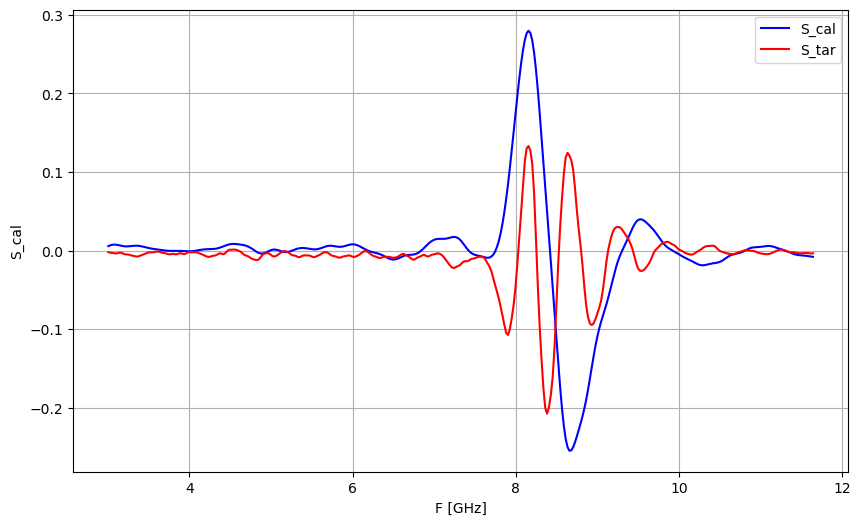

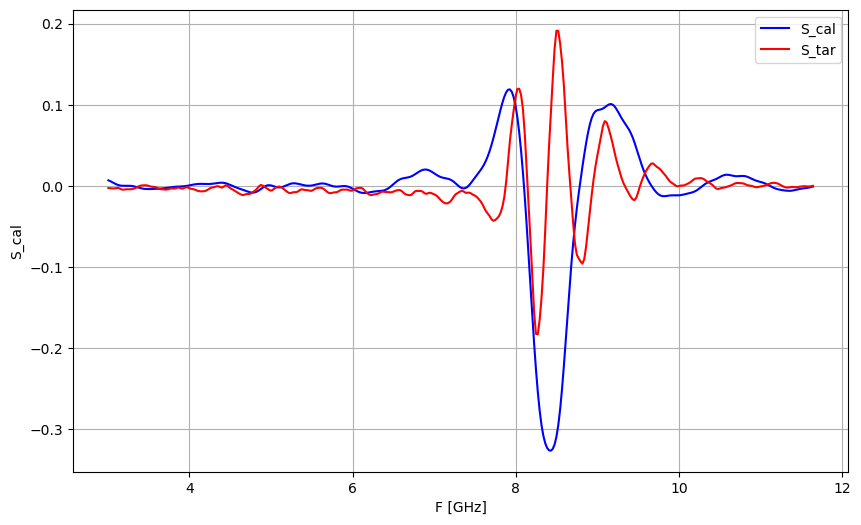

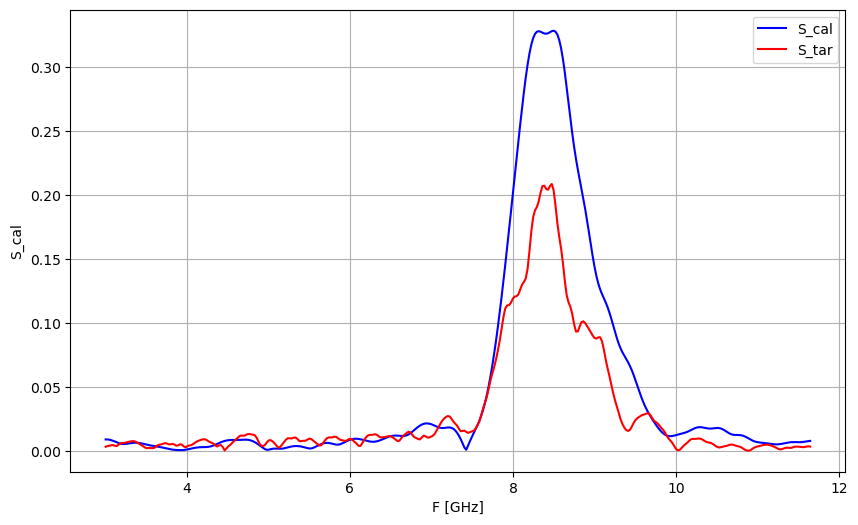

In [17]:
print('Comparo Scal y Star')
print()
print()
plt.figure(figsize=(10,6))
plt.plot(f_pos/1e9,np.real(Scal_avg_fpos),'b',label="S_cal")
plt.plot(f_pos/1e9,np.real(Star_avg_fpos),'r',label="S_tar")
plt.grid('on')
plt.legend(loc="best")
plt.xlabel('F [GHz]')
plt.ylabel('S_cal')
plt.show()
print()
print()

plt.figure(figsize=(10,6))
plt.plot(f_pos/1e9,np.imag(Scal_avg_fpos),'b',label="S_cal")
plt.plot(f_pos/1e9,np.imag(Star_avg_fpos),'r',label="S_tar")
plt.grid('on')
plt.legend(loc="best")
plt.xlabel('F [GHz]')
plt.ylabel('S_cal')
plt.show()


plt.figure(figsize=(10,6))
plt.plot(f_pos/1e9,np.abs(Scal_avg_fpos),'b',label="S_cal")
plt.plot(f_pos/1e9,np.abs(Star_avg_fpos),'r',label="S_tar")
plt.grid('on')
plt.legend(loc="best")
plt.xlabel('F [GHz]')
plt.ylabel('S_cal')
plt.show()
